In [1]:
import numpy as np
import deeptrack as dt
import deeplay as dl
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import random


In [2]:
image = dt.LoadImage("cope_1.png")
plt.figure(figsize=(15, 10))
image = np.array(image.resolve()) #Note to self, resolve() makes it into a list
print(np.shape(image))
#plt.imshow(image)

(5202, 3464, 3)


<Figure size 1500x1000 with 0 Axes>

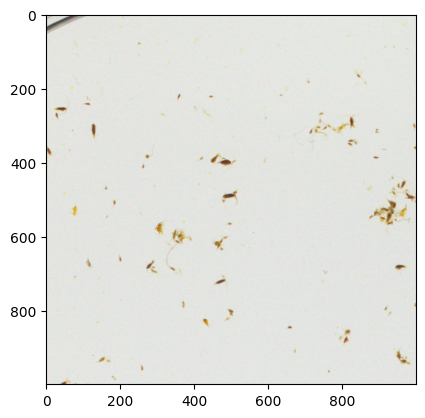

In [37]:
crop_size =1000
y_index = 770
x_index = 1590
x0,y0 = y_index-crop_size // 2, x_index - crop_size//2
training_image = np.array(   image[x0:x0+crop_size, y0: y0 + crop_size])
plt.imshow(training_image)

# Prepare cropped sample

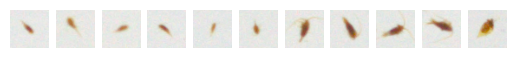

In [4]:

'''
crops from cope_2.png:

crop_size = 30
y_index = 1770
x_index = 608

crop_size = 35
y_index = 1675
x_index = 450
'''

crop_size = 45
ys    = [1875, 1864, 2345, 1740, 1610, 1487, 1970, 1480,1525,1945,1430]
xs    = [1785,  920, 1070, 1825, 1975, 1550,  850, 1595,1517,1230,2395]
training_images = []
number_of_crops = len(ys)
#x0,y0 = y_index-crop_size // 2, x_index - crop_size//2
#training_image = np.array(   image[x0:x0+crop_size, y0: y0 + crop_size])


for i in range(number_of_crops):
    #go through the positions for the crops
    y_index   = ys[i]
    x_index   = xs[i]
    
    x0,y0 = y_index-crop_size // 2, x_index - crop_size//2

    
    training_image = np.array(   image[x0:x0+crop_size, y0: y0 + crop_size])
    training_images.append(training_image)
    plt.subplot(1,number_of_crops,i+1)
    plt.axis("off")
    plt.imshow(training_image)

random_crop = dt.Value(lambda: random.choice(training_images))
#np.expand_dims(training_images, axis=-1)

    


In [5]:
downsample = 2
training_pipeline = (
    dt.Value(random_crop)
    >> dt.AveragePooling(ksize=(downsample, downsample, 1))
    >> dt.Multiply(lambda: np.random.uniform(0.9, 1.1))
    >> dt.Add(lambda: np.random.uniform(-0.1, 0.1))
    >> dt.MoveAxis(-1, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)
training_dataset = dt.pytorch.Dataset(training_pipeline, length=600, replace=False)

In [6]:
dataloader = dl.DataLoader(training_dataset,batch_size=8,shuffle=True,num_workers=6)

/home/alex/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Train LodeSTAR with cropped sample

In [7]:
epochs = 15
lodestar = dl.LodeSTAR(n_transforms=4,optimizer=dl.Adam(lr=1e-4)).build()
trainer = dl.Trainer(max_epochs=epochs)
trainer.fit(lodestar,dataloader)

/home/alex/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
2024-04-02 15:18:29.786605: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-02 15:18:30.478232: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/alex/.local/lib/python3.10/site-packages/cv2/../../lib64:
2024-04-02 15:18:30.478310: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
202

Epoch 14: 100%|██████████| 75/75 [00:10<00:00,  7.24it/s, v_num=33, train_between_image_disagreement_step=0.086, train_within_image_disagreement_step=0.0242, train_between_image_disagreement_epoch=0.0748, train_within_image_disagreement_epoch=0.0228]


# Evaluate Performance

Text(0.5, 1.0, 'Predicted image')

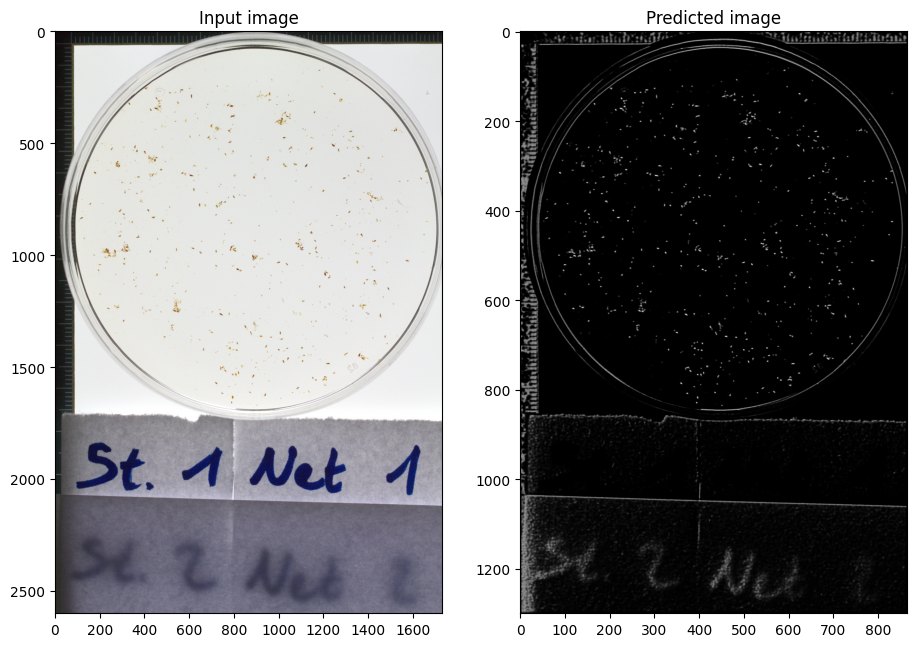

In [8]:
#Prepare test image:
#crop_size= 2600
#y_index = 1900
#x_index = 1700
#x0,y0 = y_index-crop_size // 2, x_index - crop_size//2
#test_image = image[x0:x0+crop_size, y0: y0 + crop_size]


#Downsample test image so it can be fed without crashing the pc
import cv2
rescale_factor = 0.5
new_width  = int(image.shape[1]*rescale_factor)
new_height = int(image.shape[0]*rescale_factor)
test_image = cv2.resize(image, (new_width,new_height),interpolation=cv2.INTER_AREA) 
torch_image = torch.from_numpy(test_image).permute(2,0,1).unsqueeze(0).float()


#Feed to LodeSTAR
prediction = lodestar(torch_image)[0].detach().numpy()

x, y, rho = prediction[0], prediction[1], prediction[-1]


plt.figure(figsize=(17,11))
plt.subplot(1,3,1)
plt.imshow(test_image)
plt.title("Input image")

plt.subplot(1,3,2)
plt.imshow(rho,cmap="gray")
plt.title("Predicted image")


#plt.subplot(1,3,3)
#plt.imshow(test_image)
#plt.scatter(y,x,alpha=rho.flatten()/rho.max(),s=0.0001)
#plt.title("input + predicted")



Detections: 453
Record = 453


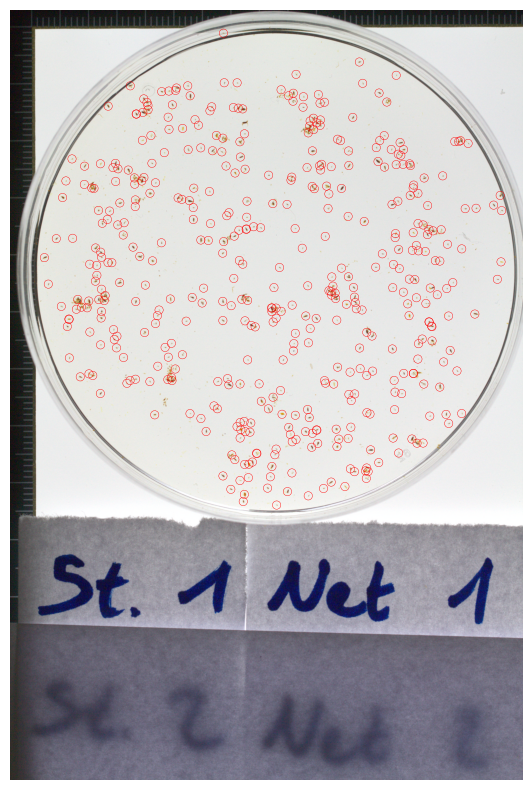

In [40]:
alpha = 0.5
beta  = 0.9

cutoff = 0.7

mode= "constant"

plt.figure(figsize=(15, 10))
   
detections = lodestar.detect(torch_image, alpha=alpha, beta=beta, 
                                 mode="constant", cutoff=cutoff)[0]

detection_number = len(detections[:,1])                          
print(f"Detections: {detection_number}")
print(f"Record = 453")
plt.imshow(test_image, cmap="gray")
plt.scatter(detections[:, 1], detections[:, 0],marker="o",facecolors="none",edgecolors='r',linewidths=0.3)
plt.axis("off")
plt.show()